In [1]:
import torch
from torch.nn import NLLLoss
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn

%matplotlib inline
import pylab as pl
from IPython import display
import time

from helpful_files.networks import Network, predict
from helpful_files.training import *
from helpful_files.testing import *

#from KiTS_dataset import KiTS_Set
from KiTS_torchio import load_KiTS_torchio #needs torchio 0.17.50
import torchio.transforms as tio

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
# Set Important Values

# General settings
datapath = './'                     # The location of your train, test, repr, and query folders. Make sure it ends in '/'!
savepath = 'myModel.pth'            # Where should your trained model(s) be saved, and under what name?
gpu = 0                             # What gpu do you wish to train on?
workers = 6                         # Number of cpu worker processes to use for data loading
epoch = 100                          # Number of passes over the dataset before the learning rate is cut
ncuts = 5                           # Number of times to cut the learning rate before training completes
verbosity = 5                       # How many batches in between status updates 
ensemble = 3                        # How many models to train in parallel
k = 2                               # Evaluate top-k accuracy. Typically 1 or 5. 
torch.cuda.set_device(gpu)
cudnn.benchmark = True
trn_pct = 0.9                       #test/val split pct

# Batch construction
way = 2                            # Number of classes per batch during training
trainshot = 2                       # Number of images per class used to form prototypes
testshot = 1                       # Number of images per class used to make predictions

num_classes = 6                    #for validation

# Model construction
folding = True                      # Use batch folding?
covariance_pooling = True           # Use covariance pooling?
localizing = True                   # Use localization?
fewshot_local = False                # If you are using localization: few-shot, or parametric? Few-shot if True, param if False
network_width = 32                  # Number of channels at every layer of the network

# Data loading
augmentation_flipping = True        # Horizontal flip data augmentation
include_masks = (localizing         # Include or ignore the bounding box annotations?
                 and fewshot_local)
data_shape = (128,128,128)


# Calculate embedding size based on model setup
d = (network_width if not 
     covariance_pooling else
     network_width**2)
if localizing and not covariance_pooling:
    d = network_width*2

In [3]:
#define transformations
flip = tio.RandomFlip()
spatial = tio.OneOf(
    {tio.RandomAffine(degrees=5, isotropic=True): 0.4, 
     tio.RandomElasticDeformation(num_control_points=5, max_displacement=4): 0.6},p=0.4)
noise = tio.RandomNoise(std=(0.05),p=0.3)
transform = tio.Compose([flip,spatial,noise])



In [4]:
# Load Training Data 
#this step takes forever 
#sampler has to iterate through whole dataset and dataset is real big


"""
d_boxes = torch.load('helpful_files/box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])
"""
if folding:
    # Batch folding has no reference/query distinction
    shots = [trainshot+testshot]
else:
    # Standard setup
    shots = [trainshot, testshot]
if localizing and fewshot_local and not folding:
    # Unfolded prototype localizers need another set of reference images to inform foreground/background predictions
    shots = [trainshot, trainshot, testshot-trainshot]
    
"""
train_dataset = datasets.ImageFolder(
    datapath+'train', 
    loader = lambda x: load_transform(x, d_boxes, transform, augmentation_flipping, include_masks))
"""
#trainset = KiTS_Set(data_shape)

#train_data,val_data = torch.utils.data.random_split(trainset,[round(trn_pct*len(trainset)), round((1-trn_pct)*len(trainset))])

#train_data = torch.utils.data.Dataset(train_data,transform=transform)

train_data, repr_data, val_data = load_KiTS_torchio(data_shape,trn_pct,transform=transform)


train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_sampler = ProtoSampler(train_data, way, shots),
    num_workers = workers,
    pin_memory = True)


val_repr_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_sampler = OrderedSampler(repr_data, shots[-1]),
    num_workers = workers,
    pin_memory = True)

val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_sampler = OrderedSampler(val_data, shots[-1]), #batch size must be equal to shots
    num_workers = workers,
    pin_memory = True)

print('Data loaded!')

100%|██████████| 21/21 [00:00<00:00, 221.99it/s]

Data loaded!


In [33]:
# Make Models
dat_flag = True #use patient data?
models = [Network(network_width, folding, covariance_pooling, 
                  localizing, fewshot_local, shots, dat_flag).cuda() 
          for i in range(ensemble)]
optimizer = [optim.Adam(m.parameters(), lr=.0001) for m in models]
scheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in optimizer]
criterion = NLLLoss().cuda()

#initialize weights
for net in models:
    for m in net.modules():
        if isinstance(m, torch.nn.Conv3d):
            torch.nn.init.kaiming_normal_(m.weight)
"""
expander = avgpool()
if localizing:
    if fewshot_local:
        expander = fsCL if covariance_pooling else fsL
    else:
        expander = pCL() if covariance_pooling else pL()
elif covariance_pooling:
    expander = covapool
expanders = [expander for _ in range(ensemble)]


if localizing and not fewshot_local:
    fbcentroids = torch.load(model[:model.rfind('.')]+'_localizers'+model[model.rfind('.'):])
    for i in range(ensemble):
        expanders[i].centroids.data = fbcentroids[i]
        expanders[i].cuda()
"""

nweights = sum([i.numel() for i in list(models[0].parameters())])
print(nweights,"parameters in each neural net.")
print('Ready to go!')

1036007 parameters in each neural net.
Ready to go!


Accuracies and 95% confidence intervals
Mean accuracy: 		73.02 	+/- 6.72
Per-class accuracy: 	31 	+/- 2.77


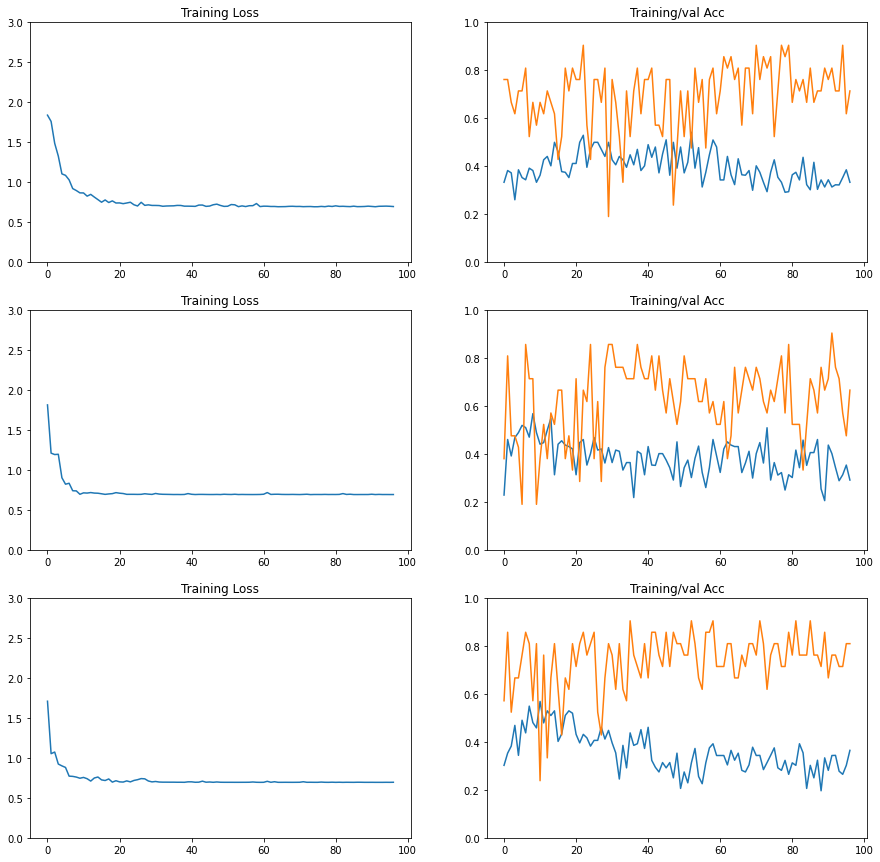

Training loss is: [0.6966040804982185, 0.6940348483622074, 0.694716639816761]
Training accuracy is: [0.3333333333333333, 0.2916666666666667, 0.3645833333333333]

Validation accuracy is: [0.7142857142857143, 0.6666666666666666, 0.8095238095238095]

Approximately 5.14 hours to completion

Training images covered this round:


Exception ignored in: <function Image.<lambda> at 0x7f6deb44a200>
Traceback (most recent call last):
  File "/home/mitch/anaconda3/envs/torch/lib/python3.7/site-packages/SimpleITK/SimpleITK.py", line 3714, in <lambda>
    __del__ = lambda self: None
KeyboardInterrupt


KeyboardInterrupt: 

In [34]:
# Do the Thing!

start = time.time()
trainlosses, acctracker = [[] for _ in range(ensemble)],[[] for _ in range(ensemble)]
valacctracker = [[] for _ in range(ensemble)]
num_classes = 6

epochs = ncuts*epoch
for e in range(epochs):
    
    # Train for one epoch
    trainloss, acc = train(train_loader, models, optimizer, criterion, way, shots, verbosity)
    
    # Update the losses
    #display.clear_output(wait=True)
    for j in range(ensemble):
        trainlosses[j].append(trainloss[j])
        acctracker[j].append(acc[j])
    
    
    #now run the validation set
    
    #create necessary vars
    expanders = [m.postprocess for m in models]
    #centroids = [e.centroids for e in expanders]
    fbcentroids = [None]*ensemble
    val_models = [m.encode for m in models]
    acclist = []
    pcacclist = []
    alldispacc = np.zeros(num_classes)
    
    centroids, counts = accumulate([m.encode for m in models], val_repr_loader, expanders, 
                                   fbcentroids, num_classes, d)
    # Score the models
    allacc, dispacc, perclassacc,targs,preds = score(k, centroids, fbcentroids, val_models, val_loader, expanders, num_classes)
    
    val_acc = allacc
    for j in range(ensemble):
        valacctracker[j].append(allacc[j])
    #print(allacc,dispacc,perclassacc)
    # Record val statistics
    acclist = acclist+allacc
    pcacclist = pcacclist+list(perclassacc)
    alldispacc += dispacc

    
    # Aggregate collected val statistics
    accs = sum(acclist)/ensemble
    pcaccs = sum(pcacclist)/ensemble
    alldispacc = alldispacc
    confs = 1.96*np.sqrt(np.var(acclist)/ensemble)
    pcconfs = 1.96*np.sqrt(np.var(pcacclist)/ensemble)

    
    display.clear_output(wait=True)
    # Report val
    print("Accuracies and 95% confidence intervals")
    print("Mean accuracy: \t\t%.2f \t+/- %.2f" % (accs*100, confs*100))
    print("Per-class accuracy: \t%.f \t+/- %.2f" % (pcaccs*100, pcconfs*100))
    
    #trn graphs
    pl.figure(1, figsize=(15,15))
    for i in range(ensemble):
        pl.subplot(ensemble,2,2*i+1)
        pl.plot(trainlosses[i])
        pl.ylim((0,3))
        pl.title("Training Loss")
        pl.subplot(ensemble,2,2*i+2)
        pl.plot(acctracker[i])
        pl.plot(valacctracker[i])
        pl.ylim((0,1))
        pl.title("Training/val Acc")
    pl.show()
    print("Training loss is: "+str(trainloss)+
            "\nTraining accuracy is: "+str(acc)+"\n")
    print("Validation accuracy is: "+str(val_acc)+"\n")
    print("Approximately %.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
    
    
    
    
    # Adjust learnrate
    if e%epoch == 0:
        [s.step() for s in scheduler]
    
print("Training complete: %.2f hours total" % ((time.time()-start)/3600)) 

In [35]:
print((targs),'\n\n\n',(preds))

[[1, 1, 1], [1, 1, 1], [1, 1, 1], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0], [0], [0], [2, 2], [2, 2], [2, 2]] 


 [[[0, 2, 1], [1, 0, 0]], [[1, 4, 4], [0, 1, 1]], [[0, 0, 2], [1, 1, 0]], [[0, 4, 0], [2, 1, 3]], [[0, 4, 3], [1, 1, 0]], [[0, 1, 0], [2, 0, 3]], [[2, 2, 0], [5, 0, 2]], [[0, 0, 0], [1, 1, 3]], [[0, 0, 4], [1, 1, 2]], [[5, 1, 2], [0, 2, 0]], [[1, 5, 0], [5, 1, 1]], [[0, 0, 0], [1, 1, 3]], [[3, 0, 0], [0, 2, 1]], [[4, 5, 0], [1, 1, 2]], [[1, 0, 0], [0, 1, 1]], [[5, 2, 4], [0, 0, 5]], [[0, 0, 1], [5, 5, 0]], [[1, 0, 3], [2, 1, 0]], [[0], [2]], [[2], [0]], [[0], [1]], [[4, 2], [5, 0]], [[4, 4], [1, 1]], [[0, 1], [2, 0]]]


In [36]:
lists = []
for i in range(len(targs)-1):
    lists+= targs[i]
print(lists)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2]


In [37]:
top1 = []
top2 = []

print(preds)
for i in range(len(targs)-1):
    #print(preds[i])
    top1+= preds[i][0]
    top2+= preds[i][1]
print(top1)

[[[0, 2, 1], [1, 0, 0]], [[1, 4, 4], [0, 1, 1]], [[0, 0, 2], [1, 1, 0]], [[0, 4, 0], [2, 1, 3]], [[0, 4, 3], [1, 1, 0]], [[0, 1, 0], [2, 0, 3]], [[2, 2, 0], [5, 0, 2]], [[0, 0, 0], [1, 1, 3]], [[0, 0, 4], [1, 1, 2]], [[5, 1, 2], [0, 2, 0]], [[1, 5, 0], [5, 1, 1]], [[0, 0, 0], [1, 1, 3]], [[3, 0, 0], [0, 2, 1]], [[4, 5, 0], [1, 1, 2]], [[1, 0, 0], [0, 1, 1]], [[5, 2, 4], [0, 0, 5]], [[0, 0, 1], [5, 5, 0]], [[1, 0, 3], [2, 1, 0]], [[0], [2]], [[2], [0]], [[0], [1]], [[4, 2], [5, 0]], [[4, 4], [1, 1]], [[0, 1], [2, 0]]]
[0, 2, 1, 1, 4, 4, 0, 0, 2, 0, 4, 0, 0, 4, 3, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 4, 5, 1, 2, 1, 5, 0, 0, 0, 0, 3, 0, 0, 4, 5, 0, 1, 0, 0, 5, 2, 4, 0, 0, 1, 1, 0, 3, 0, 2, 0, 4, 2, 4, 4]


[[25.  6.  5.  3.  5.  4.]
 [ 3.  2.  2.  0.  2.  0.]
 [ 0.  0.  1.  0.  3.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


/home/mitch/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/mitch/anaconda3/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


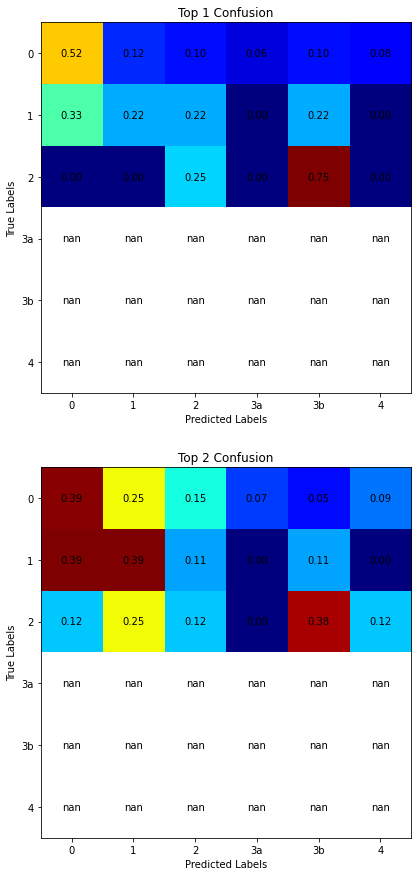

In [38]:
#confusion matrix

mtrx = np.zeros((6,6))
mtrx2 = np.zeros((6,6))
for true,guess in zip(lists,top1):
    mtrx[true,guess] +=1
for true,guess in zip(lists+lists,top1+top2):
    mtrx2[true,guess] +=1
print(mtrx)

#normalize
mtrx = (mtrx - mtrx.min())/(mtrx.max() - mtrx.min())
mtrx2 = (mtrx2 - mtrx2.min())/(mtrx2.max() - mtrx2.min())
row_sums = mtrx.sum(axis=1)
mtrx = mtrx / row_sums[:, np.newaxis]
row_sums = mtrx2.sum(axis=1)
mtrx2 = mtrx2 / row_sums[:, np.newaxis]

pl.figure(2, figsize=(15,15))
pl.subplot(2,1,1)
pl.imshow(mtrx,cmap='jet')
pl.xticks(np.arange(6),['0','1','2','3a','3b','4'])
pl.yticks(np.arange(6),['0','1','2','3a','3b','4'])
pl.title('Top 1 Confusion')
pl.xlabel('Predicted Labels')
pl.ylabel('True Labels')

for i in range(6):
    for j in range(6):
        text = pl.text(j, i, "{:.2f}".format(mtrx[i, j]),
                       ha="center", va="center", color="k")
pl.figure(2, figsize=(15,15))
pl.subplot(2,1,2)
pl.imshow(mtrx2,cmap='jet')
pl.xticks(np.arange(6),['0','1','2','3a','3b','4'])
pl.yticks(np.arange(6),['0','1','2','3a','3b','4'])
pl.title('Top 2 Confusion')
pl.xlabel('Predicted Labels')
pl.ylabel('True Labels')
for i in range(6):
    for j in range(6):
        text = pl.text(j, i, "{:.2f}".format(mtrx2[i, j]),
                       ha="center", va="center", color="k")



In [9]:
# Save the model

torch.save([m.encode.cpu().state_dict() for m in models], savepath)

# If using parametric localization, save the extra parameters
if localizing and not fewshot_local:
    torch.save([m.postprocess.centroids.cpu() for m in models], 
               savepath[:savepath.rfind('.')]+'_localizers'+savepath[savepath.rfind('.'):])
print("Models saved!")

Models saved!
